<a href="https://colab.research.google.com/github/abhigyan13/YOLACT_Instance_segmentation/blob/main/yolact_train_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
dtype = torch.cuda.FloatTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data
import sys
sys.path.append('drive/MyDrive/YOLACT/')
from utils.box_utils import match, crop, make_anchors
from utils.output_utils import *
from utils.augmentation import val_aug , train_aug
from architect import *
from config import*
import pdb
import time
import pickle
import cv2
import numpy as np
import glob
from PIL import Image
from numpy import asarray
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

In [62]:

class Yolact(nn.Module):
  def __init__(self , cfg ):
    super().__init__()
    self.cfg = cfg
    self.anchors = []
    self.backbone = Resnet() #Construct Resnet Backbone
    self.fpn = FPN([512 , 1024 , 2048]) #Construct FPN
    self.protonet = Protonet() #Construct Protonet
    self.prediction_layers = nn.ModuleList()
    self.prediction_layers.append(Prediction_module(cfg, coefdim= 32)) #Construct Prediction Module
    self.device = torch.device('cuda')
    if cfg.mode == 'train':
      ch_out = cfg.num_classes - 1
      self.semantic_seg_conv = nn.Conv2d(256, ch_out, kernel_size=1) #semantic_seg_conv only during training


  def load_weights(self, path):
    if torch.cuda.is_available():
      state_dict = torch.load(path)
    else:
      state_dict = torch.load(path, map_location='cpu')

    for key in list(state_dict.keys()):
    # 'fpn.downsample_layers.2.weight' and 'fpn.downsample_layers.2.bias'
    # in the pretrained .pth are redundant, remove them
      if key.startswith('fpn.downsample.'):
        if int(key.split('.')[2]) >= 2:
          del state_dict[key]

      if self.cfg.mode != 'train' and key.startswith('semantic_seg_conv'):
        del state_dict[key]

    self.load_state_dict(state_dict)



  def init_weights(self):
        # Initialize the backbone with the pretrained weights.
        self.backbone.init_resnet()
        # Initialize the rest conv layers with xavier
        for name, module in self.named_modules():
          if isinstance(module, nn.Conv2d) and not name.startswith('backbone'):
            nn.init.xavier_uniform_(module.weight.data)

            if module.bias is not None:
              module.bias.data.zero_()



  def forward( self , img , box_classes = None , masks_gt = None ):
    #pass through resnet and construct FPN
    with torch.no_grad():
      outs = self.backbone(img)
    outs = self.fpn(outs)
    #specify anchor boxes in predicted image
    if isinstance(self.anchors, list):
      for i, shape in enumerate([list(aa.shape) for aa in outs]):
        self.anchors += make_anchors(self.cfg, shape[2], shape[3], self.cfg.scales[i])

      self.anchors = torch.tensor(self.anchors, device=outs[0].device).reshape(-1, 4)
    #pass fpn out0 from protonet to generate prototypes
    proto_out = self.protonet(outs[0])
    proto_out = F.relu(proto_out, inplace=True)
    proto_out = proto_out.permute(0, 2, 3, 1).contiguous()

    class_pred , box_pred , coef_pred  = [] , [] , [] #make list to store predicted anchor boxes
    for out in outs:
      class_p , box_p , coef_p = self.prediction_layers[0](out) #Pass each output of FPN to get anchor boxes prediction
      class_pred.append(class_p)
      box_pred.append(box_p)
      coef_pred.append(coef_p)
    
    #concat all predictions to get shape (19248 , _type )
    class_pred = torch.cat(class_pred, dim=1) #(19248 , 21)
    box_pred = torch.cat(box_pred, dim=1)     #(19248 , 4)
    coef_pred = torch.cat(coef_pred, dim=1)   #(19248 , 32)

    if self.training:
      seg_pred = self.semantic_seg_conv(outs[0])
      return self.compute_loss(class_pred, box_pred, coef_pred, proto_out, seg_pred, box_classes , masks_gt)
    else:
      class_pred = F.softmax(class_pred, -1)
      return class_pred, box_pred, coef_pred, proto_out, self.anchors
  
  def compute_loss( self , class_p , box_p , coef_p , proto_p , seg_p , box_class , mask_gt  ):
    device = torch.device('cuda')
    class_gt = [None] * len(box_class)
    batch_size = box_p.size(0)
    num_anchors = self.anchors.shape[0]
    
    all_offsets = torch.zeros((batch_size, num_anchors, 4), dtype=torch.float32, device=device)
     # all_offsets: the transformed box coordinate offsets of each pair of anchor and gt box
    conf_gt = torch.zeros((batch_size, num_anchors), dtype=torch.int64, device=device)
     # conf_gt: the foreground and background labels according to the 'pos_thre' and 'neg_thre', 0 means background, '>0' means foreground.
    anchor_max_gt = torch.zeros((batch_size, num_anchors, 4), dtype=torch.float32, device=device)
     # anchor_max_gt: the corresponding max IoU gt box for each anchor
    anchor_max_i = torch.zeros((batch_size, num_anchors), dtype=torch.int64, device=device)
     # anchor_max_i: the index of the corresponding max IoU gt box for each anchor

    #create training ground truth data
    for i in range(batch_size):
      box_gt = box_class[i][:, :-1] #first 4 values contain cordinates
      class_gt[i] = box_class[i][:, -1].long() #last value contains ground truth class
      all_offsets[i], conf_gt[i], anchor_max_gt[i], anchor_max_i[i] = match(self.cfg, box_gt, self.anchors, class_gt[i]) # Match corresponding anchor box

    # only compute losses from positive samples
    pos_bool = conf_gt > 0  # (n, 19248)

    loss_c = self.category_loss(class_p, conf_gt, pos_bool)
    loss_b = self.box_loss(box_p, all_offsets, pos_bool)
    loss_m = self.lincomb_mask_loss(pos_bool, anchor_max_i, coef_p, proto_p, mask_gt, anchor_max_gt)
    loss_s = self.semantic_seg_loss(seg_p, mask_gt, class_gt)

    return loss_c, loss_b, loss_m, loss_s
  

  def category_loss(self, class_p, conf_gt, pos_bool, np_ratio=3):
    # Compute max conf across batch for hard negative mining
    batch_conf = class_p.reshape(-1, self.cfg.num_classes) 
    batch_conf_max = batch_conf.max() #substract max for numerical stability
    mark = torch.log(torch.sum(torch.exp(batch_conf - batch_conf_max), 1)) + batch_conf_max - batch_conf[:, 0]

    mark = mark.reshape(class_p.size(0), -1)  # (n, 19248)
    mark[pos_bool] = 0  # filter out pos boxes
    mark[conf_gt < 0] = 0  # filter out neutrals (conf_gt = -1)

    _, idx = mark.sort(1, descending=True)
    _, idx_rank = idx.sort(1)

    num_pos = pos_bool.long().sum(1, keepdim=True)
    num_neg = torch.clamp(np_ratio * num_pos, max=pos_bool.size(1) - 1)
    neg_bool = idx_rank < num_neg.expand_as(idx_rank)

    # Just in case there aren't enough negatives, don't start using positives as negatives
    neg_bool[pos_bool] = 0
    neg_bool[conf_gt < 0] = 0  # Filter out neutrals

    # Confidence Loss Including Positive and Negative Examples
    class_p_mined = class_p[(pos_bool + neg_bool)].reshape(-1, self.cfg.num_classes)
    class_gt_mined = conf_gt[(pos_bool + neg_bool)]

    return self.cfg.conf_alpha * F.cross_entropy(class_p_mined, class_gt_mined, reduction='sum') / num_pos.sum() #cross entropy loss

  def box_loss(self, box_p, all_offsets, pos_bool):
    num_pos = pos_bool.sum()
    pos_box_p = box_p[pos_bool, :] #use only positive samples
    pos_offsets = all_offsets[pos_bool, :]

    return self.cfg.bbox_alpha * F.smooth_l1_loss(pos_box_p, pos_offsets, reduction='sum') / num_pos #smooth l1 regression box loss

  def lincomb_mask_loss(self, pos_bool, anchor_max_i, coef_p, proto_p, mask_gt, anchor_max_gt):
    proto_h, proto_w = proto_p.shape[1:3]
    total_pos_num = pos_bool.sum()
    loss_m = 0
    for i in range(coef_p.size(0)):  # coef_p.shape: (n, 19248, 32)
      # downsample the gt mask to the size of 'proto_p' 
      downsampled_masks = F.interpolate(mask_gt[i].unsqueeze(0), (proto_h, proto_w), mode='bilinear',
                                              align_corners=False).squeeze(0)
      downsampled_masks = downsampled_masks.permute(1, 2, 0).contiguous()  # (138, 138, num_objects) every ground truth object has one mask
      # binarize the gt mask because of the downsample operation
      downsampled_masks = downsampled_masks.gt(0.5).float()

      pos_anchor_i = anchor_max_i[i][pos_bool[i]]
      pos_anchor_box = anchor_max_gt[i][pos_bool[i]]
      pos_coef = coef_p[i][pos_bool[i]]

      if pos_anchor_i.size(0) == 0: #if no positive samples , continue
        continue
      # If number of positive anchors exceeds the number of masks for training, select a random subset
      old_num_pos = pos_coef.size(0)
      if old_num_pos > self.cfg.masks_to_train:
        perm = torch.randperm(pos_coef.size(0))
        select = perm[:self.cfg.masks_to_train]
        pos_coef = pos_coef[select]
        pos_anchor_i = pos_anchor_i[select]
        pos_anchor_box = pos_anchor_box[select]

      num_pos = pos_coef.size(0)
      pos_mask_gt = downsampled_masks[:, :, pos_anchor_i]

      # mask assembly by linear combination ,  @ means dot product
      mask_p = torch.sigmoid(proto_p[i] @ pos_coef.t())  # mask_p.shape: (138, 138, num_pos)
      mask_p = crop(mask_p, pos_anchor_box)  # pos_anchor_box.shape: (num_pos, 4)
      mask_loss = F.binary_cross_entropy(torch.clamp(mask_p, 0, 1), pos_mask_gt, reduction='none')
      # aa = -pos_mask_gt*torch.log(mask_p) - (1-pos_mask_gt) * torch.log(1-mask_p)
      # Normalize the mask loss to emulate roi pooling's effect on loss.
      anchor_area = (pos_anchor_box[:, 2] - pos_anchor_box[:, 0]) * (pos_anchor_box[:, 3] - pos_anchor_box[:, 1])
      mask_loss = mask_loss.sum(dim=(0, 1)) / anchor_area

      if old_num_pos > num_pos:
        mask_loss *= old_num_pos / num_pos  

      loss_m += torch.sum(mask_loss)

    return self.cfg.mask_alpha * loss_m / proto_h / proto_w / total_pos_num

  def semantic_seg_loss(self, segmentation_p, mask_gt, class_gt):
    # classes here exclude the background class, so num_classes = cfg.num_classes-1
    batch_size, num_classes, mask_h, mask_w = segmentation_p.size()  # (n, 20, 69, 69)
    loss_s = 0
    for i in range(batch_size):
      cur_segment = segmentation_p[i]
      cur_class_gt = class_gt[i]
      downsampled_masks = F.interpolate(mask_gt[i].unsqueeze(0), (mask_h, mask_w), mode='bilinear',
                                              align_corners=False).squeeze(0)
      downsampled_masks = downsampled_masks.gt(0.5).float()  # (num_objects, 69, 69)

      # Construct Semantic Segmentation
      segment_gt = torch.zeros_like(cur_segment, requires_grad=False)
      for j in range(downsampled_masks.size(0)):
        segment_gt[cur_class_gt[j]] = torch.max(segment_gt[cur_class_gt[j]], downsampled_masks[j])
      loss_s += F.binary_cross_entropy_with_logits(cur_segment, segment_gt, reduction='sum')

    return self.cfg.semantic_alpha * loss_s / mask_h / mask_w / batch_size







In [63]:

# Prepare dataset using dataloader

def train_collate(batch):
  imgs, targets, masks = [], [], []
  valid_batch = [aa for aa in batch if aa[0] is not None]

  lack_len = len(batch) - len(valid_batch)
  if lack_len > 0:
    for i in range(lack_len):
      valid_batch.append(valid_batch[i])

  for sample in valid_batch:
    imgs.append(torch.tensor(sample[0], dtype=torch.float32))
    targets.append(torch.tensor(sample[1], dtype=torch.float32))
    masks.append(torch.tensor(sample[2], dtype=torch.float32))

  return torch.stack(imgs, 0), targets, masks

def detect_collate(batch):
    imgs = torch.tensor(batch[0][0], dtype=torch.float32).unsqueeze(0)
    return imgs, batch[0][1], batch[0][2]

  
class Pascal_Detection(data.Dataset):
  def __init__(self, cfg  , mode = 'train' ):
    self.mode = mode
    self.cfg = cfg
    if(mode == 'train'):
      path = '/content/drive/MyDrive/YOLACT/VOCdevkit/VOC2012/' #specify_later
      self.image_path = glob.glob(path+'JPEGImages/*.*')
      self.image_path.sort()
      self.seg_path = glob.glob(path+'SegmentationObject/*.*')
      self.seg_path.sort()
      open_file=open( '/content/drive/MyDrive/YOLACT/VOCdevkit/VOC2012/box.pkl','rb')
      self.list_with_all_boxes =pickle.load(open_file)
      open_file.close()
      print('len of impath ' , len(self.image_path))
    elif self.mode=='detect':
      self.img_path=cfg.test_image_path


  def __getitem__(self,index ):
    if self.mode=='detect':
      image=cv2.imread(self.img_path)
      image_normed=val_aug(image,self.cfg.img_size)
      return image_normed,image,self.img_path.split('/')[-1]
    img_path = self.image_path[index]
    seg_path = self.seg_path[index]
    img = cv2.imread(img_path)
    maskgt =  Image.open(seg_path)
    maskgt = asarray(maskgt)
    h,w,_ = img.shape
    boxgt = self.list_with_all_boxes[index]
    box_list , mask_list , label_list = [] , [] , []
    for i , b in enumerate(boxgt):
      boxt = np.array([b[0],b[1],b[2],b[3]])
      labelt = cfg.label_id[b[4]] #class to class_id
      maskt = (maskgt==i+1).astype(float) #create mask per object
      box_list.append(boxt.astype(float))
      label_list.append(labelt)
      mask_list.append(maskt)
    
    if len(box_list) > 0:
      boxes = np.array(box_list)
      masks = np.stack(mask_list, axis=0)
      labels = np.array(label_list)
      if self.mode == 'train':
        img, masks, boxes, labels = train_aug(img, masks, boxes, labels, self.cfg.img_size)
        if img is None:
          return None, None, None
        else:
          boxes = np.hstack((boxes, np.expand_dims(labels, axis=1)))
          return img, boxes, masks
    
    else:
      print(f'No valid object in image: {index}. Use a repeated image in this batch.')
      return None, None, None


  def __len__(self):
    if self.mode == 'train':
      return len(self.image_path)
    else:
      return 1
    







---> **DETECT**

USE the following for detecting segmentation in the image . Specify path of test image / video in cfg.test_image_path and path of trained weights . Change mode in config to detect.


This is   person


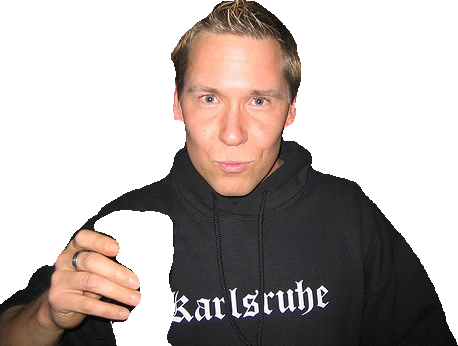

This is   bottle


This is   bottle


This is   bottle


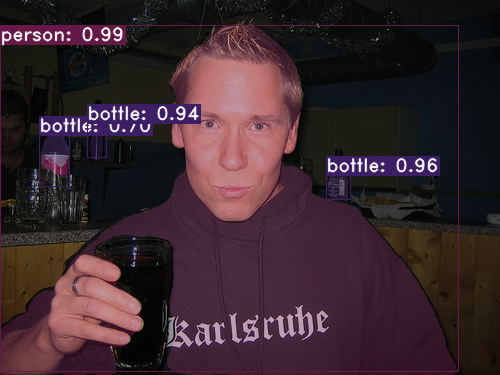

In [66]:

cfg = set_config()
cfg.cutout = True 
cfg.visual_thre = 0.3
cfg.nms_iou_thre = 0.05
cfg.nms_score_thre = 0.5

cfg.mode='detect'
cfg.test_image_path =  '/content/drive/MyDrive/YOLACT/test/i1.jpg'
net=Yolact(cfg).to(device)
path="/content/drive/MyDrive/YOLACT/weights4/latest_resnet50_pascal_19.pth"
net.load_weights(path)
net.eval()

with torch.no_grad():

  if cfg.test_image_path is not None:
    dataset= Pascal_Detection(cfg , mode='detect')
    data_loader=data.DataLoader(dataset,1,shuffle=False,pin_memory=True,collate_fn=detect_collate)
    for i, (img, img_origin, img_name) in enumerate(data_loader):
      
      if torch.cuda.is_available():
        img=img.cuda()
      img_h,img_w=img_origin.shape[0:2]
      class_p,box_p,coef_p,proto_p,anchors=net(img)

      ids_p, class_p, box_p, coef_p, proto_p = nms(class_p, box_p, coef_p, proto_p, anchors, cfg)
      ids_p, class_p, boxes_p, masks_p = after_nms(ids_p, class_p, box_p, coef_p,
                                                             proto_p, img_h, img_w, cfg, img_name=img_name)
      # uncomment to show masks
      """
      j = 0
      for m in masks_p:
        print('This is ' , cfg.pascal_classes[ids_p[j]] )
        plt.imshow(m.cpu())
        plt.show()
        j+=1
      """
      img_numpy = draw_img(ids_p, class_p, boxes_p, masks_p, img_origin, cfg, img_name=img_name)
      cv2_imshow(img_numpy)
      if cfg.real_time:
        cv2.imshow('Detection', frame_numpy)
        cv2.waitKey(1)
      else:
        cv2.imwrite('/content/drive/MyDrive/YOLACT/result2/'+img_name, img_numpy)
  
  elif cfg.video is not None:
    vid = cv2.VideoCapture(cfg.video)
    target_fps = round(vid.get(cv2.CAP_PROP_FPS))
    frame_width = round(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = round(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    num_frames = round(vid.get(cv2.CAP_PROP_FRAME_COUNT))

    name = cfg.video.split('/')[-1]
    video_writer = cv2.VideoWriter(f'drive/MyDrive/YOLACT/results/{name}', cv2.VideoWriter_fourcc(*"mp4v"), target_fps,
                                       (frame_width, frame_height))
    t_fps = 0
    for i in range(num_frames):
      frame_origin = vid.read()[1]
      img_h, img_w = frame_origin.shape[0:2]
      frame_trans = val_aug(frame_origin, cfg.img_size)
      frame_tensor = torch.tensor(frame_trans).float()
      if torch.cuda.is_available():
        frame_tensor = frame_tensor.cuda()
      class_p, box_p, coef_p, proto_p, anchors = net(frame_tensor.unsqueeze(0))
      ids_p, class_p, box_p, coef_p, proto_p = nms(class_p, box_p, coef_p, proto_p, anchors, cfg)
      ids_p, class_p, boxes_p, masks_p = after_nms(ids_p, class_p, box_p, coef_p,
                                                             proto_p, img_h, img_w, cfg)
      frame_numpy = draw_img(ids_p, class_p, boxes_p, masks_p, frame_origin, cfg, fps=t_fps)
      video_writer.write(frame_numpy)
    vid.release()
    video_writer.release()


**--->TRAIN**

First load the pasacl voc dataset by calling Pascal_Detection class . Set a data loader , specify the optimizer . When running for the first time , set cfg.resume = False so as to initilize weights . There after resume training with the specified weights saved in path /YOLACT/weights4 

In [ ]:
import torch.backends.cudnn as cudnn
torch.autograd.set_detect_anomaly(True)
net = Yolact(cfg).to(device)
net.train()
if cfg.resume:
  wtemp = glob.glob("/content/drive/MyDrive/YOLACT/weights4/latest*")
  net.load_weights(wtemp[0])
  start_step = int(wtemp[0].split('.pth')[0].split('_')[-1])+1
  print(f'\nResume training with \'{start_step}\'.\n')

else:
  net.init_weights()
  print(f'\nTraining from begining, weights initialized \n')
  start_step = 0 
  cfg.resume = True

dataset = Pascal_Detection( cfg )
optimizer =optim.SGD(net.parameters(),lr=cfg.lr,momentum=0.9,weight_decay=5e-4)
data_loader= DataLoader(dataset,cfg.batch_size,shuffle=True,collate_fn=train_collate)

training = True
time_last = time.time()
step = start_step

while training:

  for i,(images,boxes,masks) in enumerate(data_loader):
    if torch.cuda.is_available():
      images = images.cuda().detach()
      boxes = [b.cuda().detach() for b in boxes]
      masks = [mask.cuda().detach() for mask in masks]

    loss_c, loss_b, loss_m, loss_s = net(images, boxes, masks)
    loss_total = loss_c + loss_b + loss_m + loss_s
    optimizer.zero_grad()
    loss_total.backward()
    optimizer.step()
    time_this = time.time()
    batch_time = time_this-time_last
    if i%30==0:
      print("Time for batch " , i , "/", len(data_loader) , "= " , batch_time , ", Loss  = " , loss_total.item() )
    time_last = time.time()

  print("Epoch no ",step ,"  completed")
  save_latest(net, cfg_name = cfg.cfg_name , step = step)
  step+=1







Resume training with '2'.

len of impath  2913
Time for batch  0 / 365 =  0.837909460067749 , Loss  =  9.450835227966309
Time for batch  30 / 365 =  0.8293414115905762 , Loss  =  11.323418617248535
Time for batch  60 / 365 =  0.8640177249908447 , Loss  =  12.482197761535645
Time for batch  90 / 365 =  0.9077968597412109 , Loss  =  10.931401252746582
Time for batch  120 / 365 =  0.8615999221801758 , Loss  =  11.922550201416016
Time for batch  150 / 365 =  0.8163743019104004 , Loss  =  8.164803504943848
Time for batch  180 / 365 =  0.8138349056243896 , Loss  =  9.401342391967773
Time for batch  210 / 365 =  0.8170185089111328 , Loss  =  9.920198440551758
Time for batch  240 / 365 =  0.8422327041625977 , Loss  =  10.820940017700195
Time for batch  270 / 365 =  0.8321285247802734 , Loss  =  10.206503868103027
Time for batch  300 / 365 =  0.8085808753967285 , Loss  =  9.000441551208496
Time for batch  330 / 365 =  0.8209505081176758 , Loss  =  9.578246116638184
Time for batch  360 / 365 = 

KeyboardInterrupt: ignored